In [3]:
import numpy as pd
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('Churn_Modelling.csv')
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Loading and exploring the dataset...
Dataset shape: (10000, 14)

First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58   

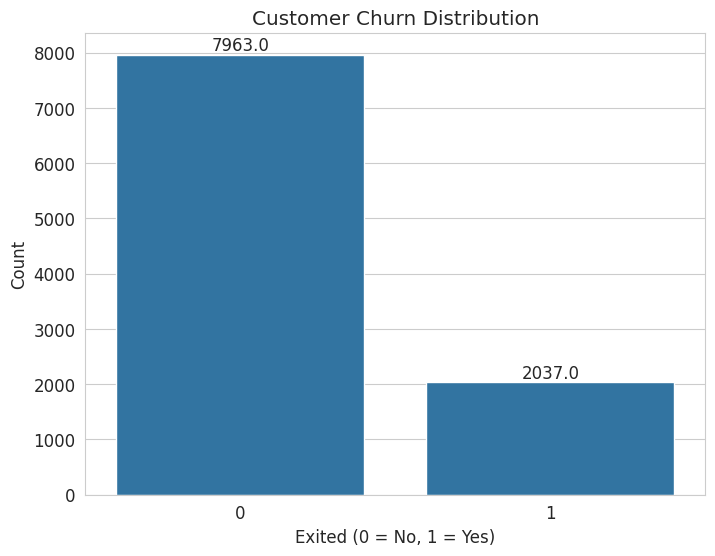

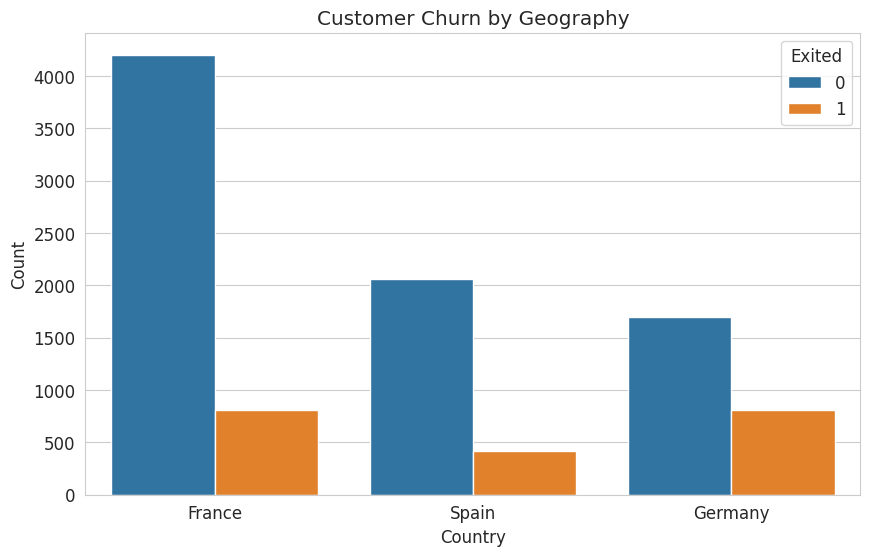

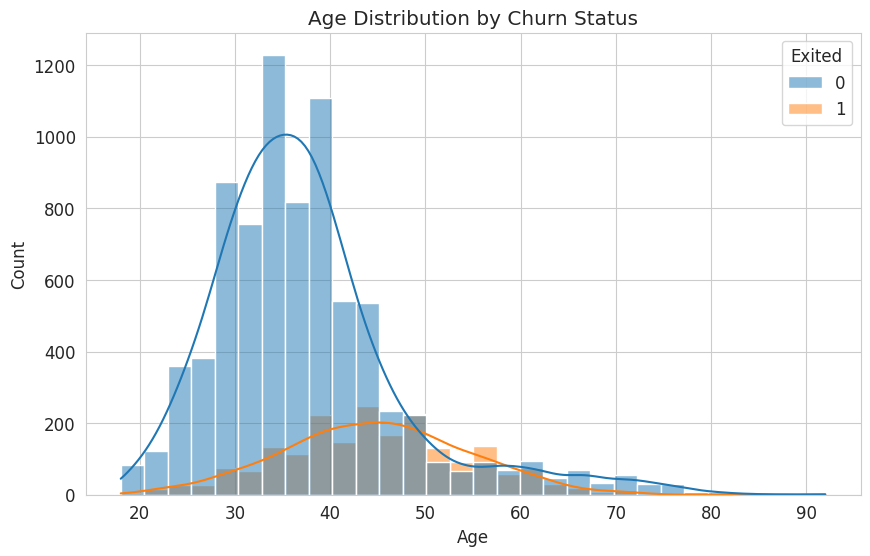

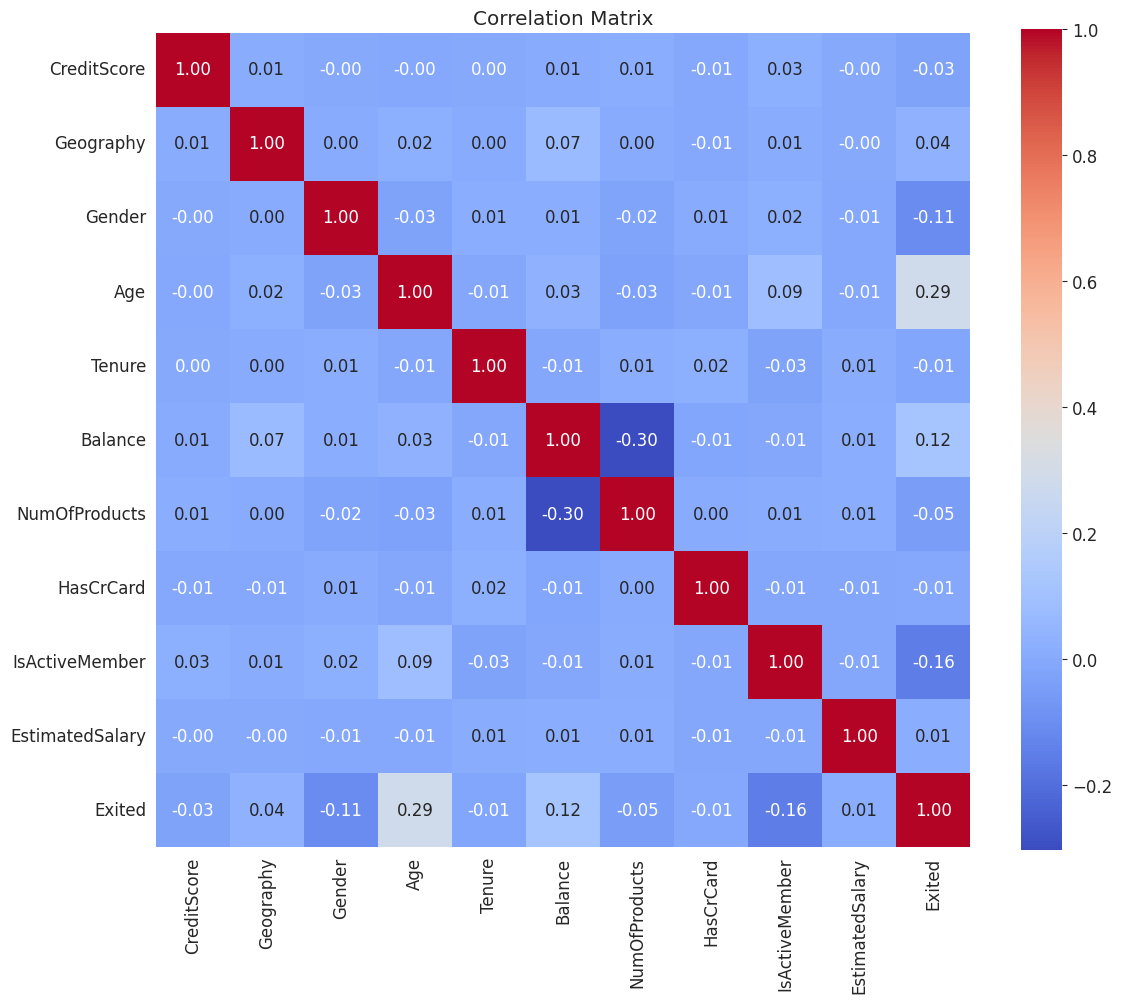

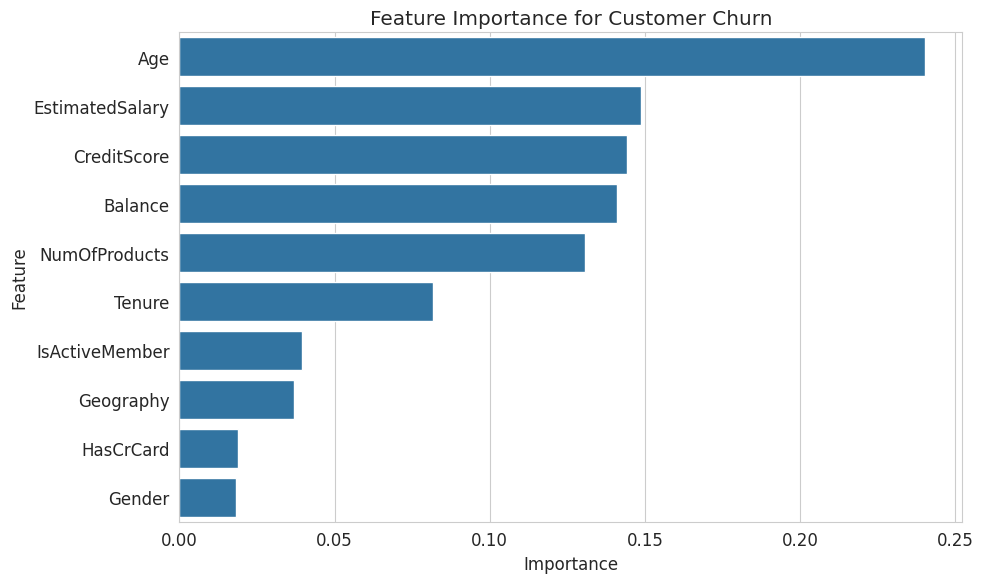

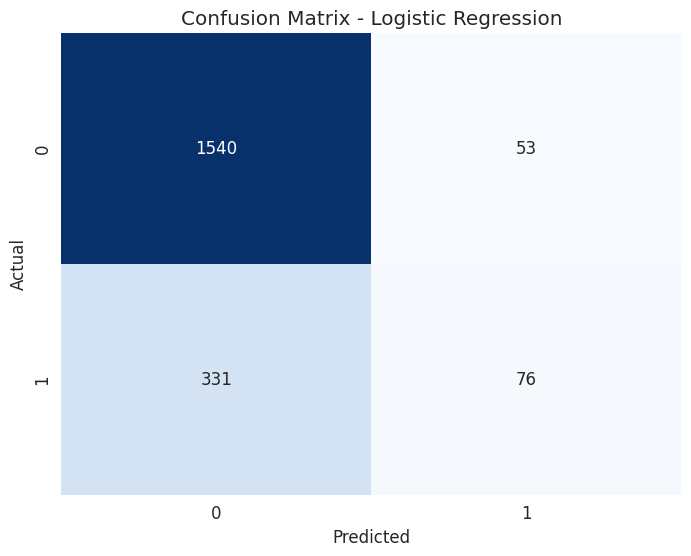

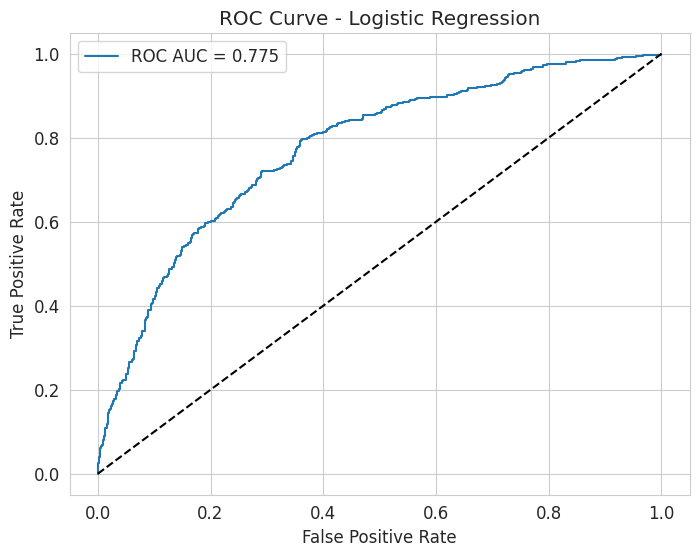

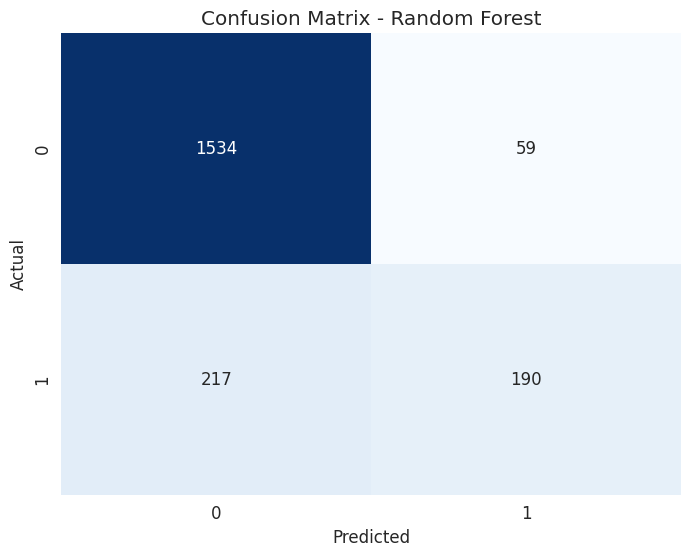

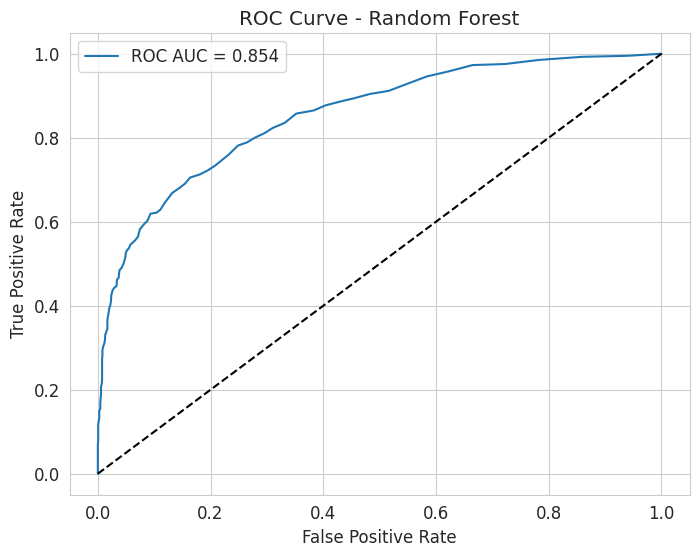

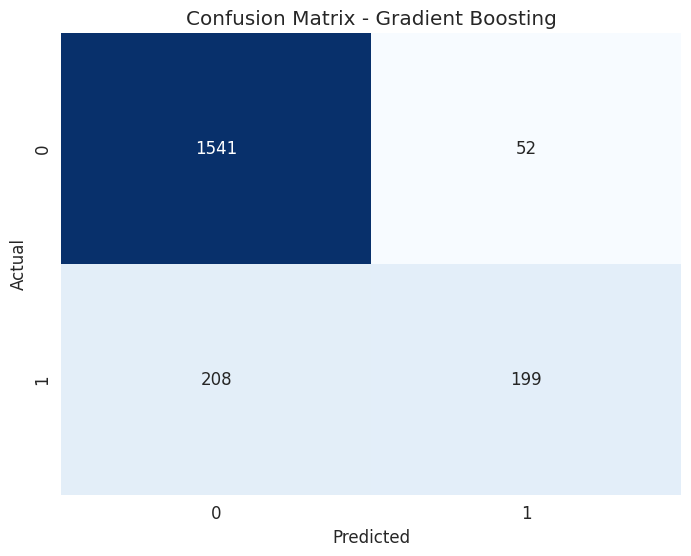

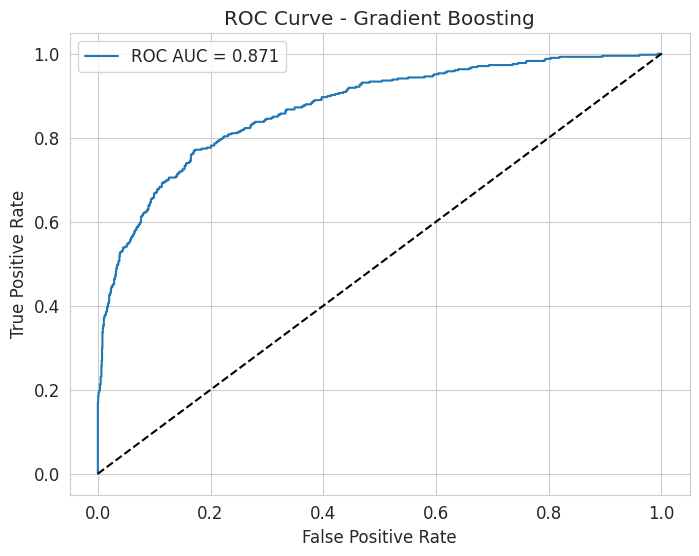

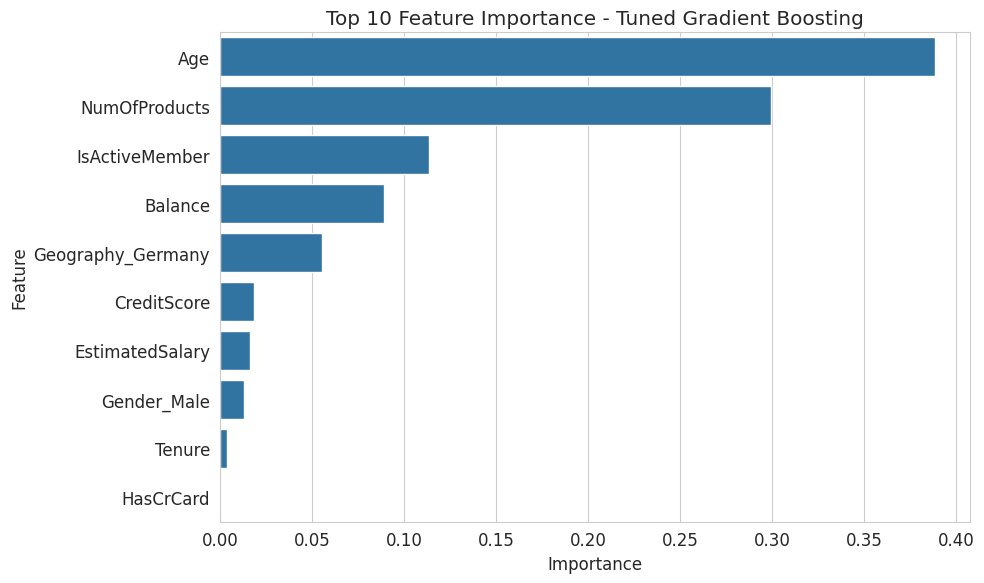

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

# Set the style for prettier plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 1. Load and explore the dataset
print("Loading and exploring the dataset...")
df = pd.read_csv('Churn_Modelling.csv')
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

# 2. Data exploration and visualization
print("\n--- Data Exploration ---")
print("\nColumn info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

print("\nTarget variable distribution (churn rate):")
churn_count = df['Exited'].value_counts()
print(churn_count)
print(f"Churn rate: {churn_count[1] / len(df) * 100:.2f}%")

# Data visualizations for better understanding
print("\nCreating exploratory visualizations...")

# Plot churn distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Exited', data=df)
plt.title('Customer Churn Distribution')
plt.xlabel('Exited (0 = No, 1 = Yes)')
plt.ylabel('Count')
# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)
plt.savefig('churn_distribution.png')
print("Churn distribution plot saved as 'churn_distribution.png'")

# Plot churn by geography
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Customer Churn by Geography')
plt.xlabel('Country')
plt.ylabel('Count')
plt.savefig('churn_by_geography.png')
print("Churn by geography plot saved as 'churn_by_geography.png'")

# Plot age distribution by churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Exited', bins=30, kde=True)
plt.title('Age Distribution by Churn Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('age_distribution_by_churn.png')
print("Age distribution plot saved as 'age_distribution_by_churn.png'")

# Correlation matrix
plt.figure(figsize=(12, 10))
# Create a copy of df with encoded categorical variables for correlation
df_corr = df.copy()
df_corr['Geography'] = LabelEncoder().fit_transform(df_corr['Geography'])
df_corr['Gender'] = LabelEncoder().fit_transform(df_corr['Gender'])

# Drop non-numeric columns that shouldn't be in correlation analysis
df_corr = df_corr.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

corr = df_corr.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
print("Correlation matrix saved as 'correlation_matrix.png'")

# 3. Data preprocessing
print("\n--- Data Preprocessing ---")

# Remove irrelevant columns
print("Removing irrelevant columns...")
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Look at distribution of categorical variables
print("\nGeography distribution:")
print(df['Geography'].value_counts())
print("\nGender distribution:")
print(df['Gender'].value_counts())

# Encode categorical variables
print("\nEncoding categorical variables...")
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# Create feature and target variables
X = df.drop('Exited', axis=1)
y = df['Exited']

# 4. Feature importance analysis using Random Forest
print("\n--- Feature Importance Analysis ---")
# We need to encode categorical features before using them in the model
X_encoded = X.copy()

# Use label encoding for categorical features
le_geography = LabelEncoder()
le_gender = LabelEncoder()

X_encoded['Geography'] = le_geography.fit_transform(X_encoded['Geography'])
X_encoded['Gender'] = le_gender.fit_transform(X_encoded['Gender'])

# Now we can fit the Random Forest
rf_for_feature = RandomForestClassifier(random_state=42)
rf_for_feature.fit(X_encoded, y)

feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_for_feature.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature importance:")
print(feature_importance)

# Optional: Create a plot of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Customer Churn')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Feature importance plot saved as 'feature_importance.png'")

# 5. Split data into training and testing sets
print("\n--- Model Training and Evaluation ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Create preprocessing pipeline
print("\nCreating preprocessing pipeline...")
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# 7. Create model pipelines
print("\nCreating model pipelines...")
models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'Gradient Boosting': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
}

# 8. Train and evaluate models
print("\nTraining and evaluating models...")
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Make predictions on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Append results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png')
    print(f"Confusion matrix saved as 'confusion_matrix_{name.replace(' ', '_').lower()}.png'")

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.savefig(f'roc_curve_{name.replace(" ", "_").lower()}.png')
    print(f"ROC curve saved as 'roc_curve_{name.replace(' ', '_').lower()}.png'")

# 9. Compare models
print("\n--- Model Comparison ---")
results_df = pd.DataFrame(results)
print(results_df)

# Find the best model based on ROC AUC
best_model_name = results_df.loc[results_df['ROC AUC'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with ROC AUC = {results_df['ROC AUC'].max():.3f}")

# 10. Hyperparameter tuning for the best model
print("\n--- Hyperparameter Tuning ---")
print(f"Performing hyperparameter tuning for {best_model_name}...")

# Different hyperparameters based on the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
else:  # Gradient Boosting
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    }

# Perform GridSearchCV
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)
y_pred_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

# Calculate metrics for tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print("\nTuned model performance:")
print(f"Accuracy: {accuracy_tuned:.3f}")
print(f"Precision: {precision_tuned:.3f}")
print(f"Recall: {recall_tuned:.3f}")
print(f"F1 Score: {f1_tuned:.3f}")
print(f"ROC AUC: {roc_auc_tuned:.3f}")

print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred_tuned))

# 11. Feature importance for the best model
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print("\n--- Feature Importance of Best Model ---")

    try:
        # Get feature names after preprocessing
        categorical_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1]['onehot'].get_feature_names_out(categorical_features))
        all_feature_names = categorical_columns + numerical_features

        # Get feature importance
        feature_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

        # Check if lengths match - if not, we need to handle this differently
        if len(all_feature_names) != len(feature_importances):
            print(f"Warning: Feature name length ({len(all_feature_names)}) doesn't match importance length ({len(feature_importances)})")
            print("Using generic feature names instead")
            all_feature_names = [f"Feature_{i}" for i in range(len(feature_importances))]

        # Create a dataframe of feature importance
        feature_importance_df = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)

        print(feature_importance_df)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
        plt.title(f'Top 10 Feature Importance - Tuned {best_model_name}')
        plt.tight_layout()
        plt.savefig('top_feature_importance_tuned_model.png')
        print("Tuned model feature importance plot saved as 'top_feature_importance_tuned_model.png'")
    except Exception as e:
        print(f"Error plotting feature importance: {e}")
        print("Feature importance analysis skipped")

# 12. Customer churn prediction function
print("\n--- Creating Prediction Function ---")

def predict_churn(customer_data, model=tuned_model):
    """
    Predict whether a customer will churn based on their data.

    Parameters:
    customer_data (pandas DataFrame): A DataFrame containing customer information
    model: The trained model to use for prediction

    Returns:
    tuple: (prediction, probability)
    """
    # Ensure the input has correct columns
    required_columns = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
                      'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                      'EstimatedSalary']

    if not all(col in customer_data.columns for col in required_columns):
        raise ValueError(f"Input data must contain all required columns: {required_columns}")

    # Make prediction
    prediction = model.predict(customer_data)
    probability = model.predict_proba(customer_data)[:, 1]

    return prediction, probability

# 13. Example usage of prediction function
print("\n--- Example Prediction ---")

# Sample customer data
sample_customer = pd.DataFrame({
    'CreditScore': [700],
    'Geography': ['France'],
    'Gender': ['Male'],
    'Age': [40],
    'Tenure': [3],
    'Balance': [60000],
    'NumOfProducts': [2],
    'HasCrCard': [1],
    'IsActiveMember': [1],
    'EstimatedSalary': [50000]
})

print("Sample customer data:")
print(sample_customer)

# Make prediction
churn_prediction, churn_probability = predict_churn(sample_customer)
print(f"\nChurn prediction: {'Yes' if churn_prediction[0] == 1 else 'No'}")
print(f"Churn probability: {churn_probability[0]:.3f}")

print("\n--- Customer Churn Prediction Project Complete ---")